# 1️⃣ **Definição do Objetivo** 🎯

Identificar padrões de transações fraudulentas e criar um modelo de detecção de fraudes baseado em dados históricos.

#  2️⃣ **Exploração e Limpeza dos Dados** ✅

<h1> Informação de todas entidades.</h1>

* Transaction_ID - ID da Transação - Tipo: object (texto).

* User_ID - ID do Usuário - Tipo: int64 (número inteiro).

* Transaction_Amount - Valor da Transação - Tipo: float64 (número decimal).

* Transaction_Type - Tipo de Transação - Tipo: object (texto).

* Time_of_Transaction - Horário da Transação - Tipo: float64 (número decimal).

* Device_Used - Dispositivo Utilizado - Tipo: object (texto).

* Location - Localização - Tipo: object (texto).

* Previous_Fraudulent_Transactions - Transações Fraudulentas Anteriores - Tipo: int64 (número inteiro).

* Account_Age - Tempo de Conta (Idade da Conta) - Tipo: int64 (número inteiro).

* Number_of_Transactions_Last_24H - Número de Transações nas Últimas 24 Horas - Tipo: int64 (número inteiro).

* Payment_Method - Método de Pagamento - Tipo: object (texto).

* Fraudulent - Fraudulenta - Tipo: int64 (número inteiro, 0 ou 1).

In [3]:
# Importei a biblioteca pandas para manipulação de dados
import pandas as pd

# Carreguei o dataset 'Fraud Detection Dataset.csv' em um DataFrame chamado df_fraud
df_fraud = pd.read_csv('Fraud Detection Dataset.csv', sep=',')

# Usei a mediana para reduzir o impacto de outliers
df_fraud.loc[:, 'Transaction_Amount'] = df_fraud['Transaction_Amount'].fillna(df_fraud['Transaction_Amount'].median())

# Usei a média para consistência do tempo médio das transações
df_fraud.loc[:, 'Time_of_Transaction'] = df_fraud['Time_of_Transaction'].fillna(df_fraud['Time_of_Transaction'].mean())

# Por ser coluna categórica, substituí os valores ausentes por um valor fixo
df_fraud.loc[:, 'Device_Used'] = df_fraud['Device_Used'].fillna('Unknown')

# Como também é uma coluna categórica, substituí por um valor fixo
df_fraud.loc[:, 'Location'] = df_fraud['Location'].fillna('Unknown')

# Utilizei a moda (valor mais frequente) para preencher valores ausentes, assumindo que o método de pagamento mais comum é a melhor escolha
df_fraud.loc[:, 'Payment_Method'] = df_fraud['Payment_Method'].fillna(df_fraud['Payment_Method'].mode()[0])

#  3️⃣ **Remoção e tratamento de duplicatas ✅**

In [4]:
# Método utilizado para remoção de dados duplicados
df_fraud.drop_duplicates(inplace=True)

# **Análise Descritiva das Transações** 🔎

In [5]:
analise_estatistica = f"""
📊 **Análise Estatística Descritiva**

--- Principais métricas que descobri ---

Média = {df_fraud['Transaction_Amount'].mean():,.2f} → Valor médio das transações

Desvio Padrão = {df_fraud['Transaction_Amount'].std():,.2f} →  Desvio Padrão

Mínimo = {df_fraud['Transaction_Amount'].min():,.2f} → Algumas transações são extremamente baixas.

Máximo = {df_fraud['Transaction_Amount'].max():,.2f} → Mostra que no dataset possui valores altos.






--- Desvio Padrão dos valores ---

Q1 (25%) = {df_fraud['Transaction_Amount'].quantile(0.25):,.2f} → 25% das transações estão abaixo desse valor.

Q2 (Mediana) = {df_fraud['Transaction_Amount'].median():,.2f} → Metade das transações está abaixo desse valor.

Q3 (75%) = {df_fraud['Transaction_Amount'].quantile(0.75):,.2f} → 75% das transações estão abaixo desse valor.





---  Alguns insights que obtive.  ---

- Valores acima de {df_fraud['Transaction_Amount'].quantile(0.75):,.2f} já são considerados altos (último quartil)

- O valor máximo ({df_fraud['Transaction_Amount'].max():,.2f}) é {df_fraud['Transaction_Amount'].max()/df_fraud['Transaction_Amount'].median():.1f}x maior que a mediana

- A média ({df_fraud['Transaction_Amount'].mean():,.2f}) > mediana ({df_fraud['Transaction_Amount'].median():,.2f})  """

print(analise_estatistica)


📊 **Análise Estatística Descritiva**

--- Principais métricas que descobri ---

Média = 2,975.64 → Valor médio das transações

Desvio Padrão = 4,935.68 →  Desvio Padrão

Mínimo = 5.03 → Algumas transações são extremamente baixas.

Máximo = 49,997.80 → Mostra que no dataset possui valores altos.






--- Desvio Padrão dos valores ---

Q1 (25%) = 1,333.37 → 25% das transações estão abaixo desse valor.

Q2 (Mediana) = 2,524.10 → Metade das transações está abaixo desse valor.

Q3 (75%) = 3,721.76 → 75% das transações estão abaixo desse valor.





---  Alguns insights que obtive.  ---

- Valores acima de 3,721.76 já são considerados altos (último quartil)

- O valor máximo (49,997.80) é 19.8x maior que a mediana

- A média (2,975.64) > mediana (2,524.10)  


# 4️⃣ **Tratamento e investigação de outliers**


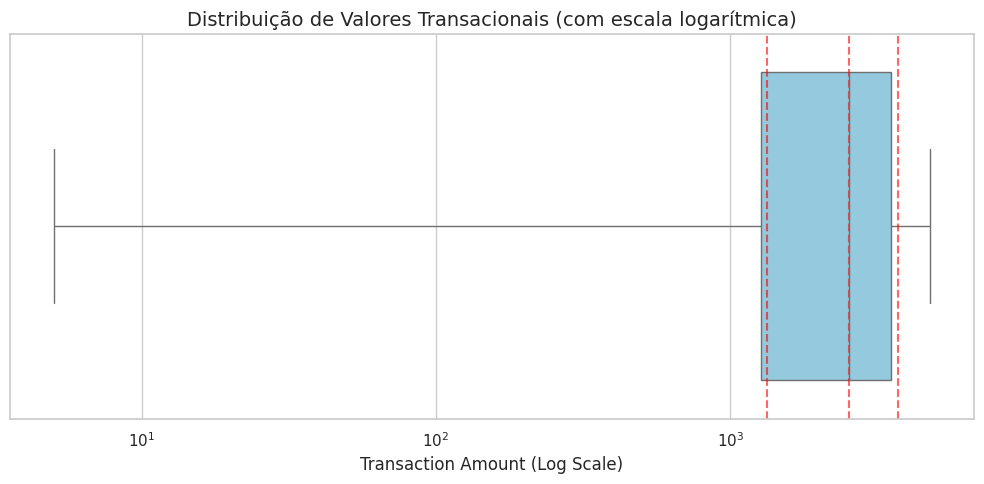

Estatísticas descritivas:
count    50119.00
mean      2975.64
std       4935.68
min          5.03
25%       1333.37
50%       2524.10
75%       3721.76
max      49997.80
Name: Transaction_Amount, dtype: float64


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Defini o estilo visual dos gráficos para melhor estética
sns.set(style="whitegrid")

# Calculei os quartis da variável Transaction_Amount (25%, 50% e 75%)
quartis = df_fraud['Transaction_Amount'].quantile([0.25, 0.5, 0.75])

# Filtrei o dataset para remover o top 5% das transações (evita distorção visual no gráfico)
filtered_df = df_fraud[df_fraud['Transaction_Amount'] < df_fraud['Transaction_Amount'].quantile(0.95)]

# Tamanho da figura.
plt.figure(figsize=(10, 5))

# Verifiquei se a coluna 'fraud' existe para separar as transações por classe (fraude/não fraude)
if 'fraud' in df_fraud.columns:
    # Cria boxplot horizontal com coloração por classe (fraude)
    sns.boxplot(data=filtered_df, x='Transaction_Amount', y='fraud', orient='h', palette='coolwarm')
else:
    # Se a coluna não existir, exibe apenas o boxplot geral
    sns.boxplot(x=filtered_df['Transaction_Amount'], color='skyblue')

# Adicionei linhas verticais nos quartis (Q1, Q2, Q3) para ajudar na leitura da distribuição
for q in quartis:
    plt.axvline(q, color='red', linestyle='--', alpha=0.6)

# Apliquei escala logarítmica no eixo X para melhor visualização da cauda longa
plt.xscale('log')

# Títulos e rótulos dos eixos
plt.title('Distribuição de Valores Transacionais (com escala logarítmica)', fontsize=14)
plt.xlabel('Transaction Amount (Log Scale)', fontsize=12)

# Ajustei o rótulo do eixo Y se a coluna 'is_fraud' estiver disponível
plt.ylabel('Fraude' if 'is_fraud' in df_fraud.columns else '')

# Ajustei layout para evitar sobreposição
plt.tight_layout()

# Exibi o gráfico
plt.show()

# --- Estatísticas descritivas ---

# Exibe estatísticas descritivas da coluna Transaction_Amount (count, mean, std, min, quartis, max)
stats = df_fraud['Transaction_Amount'].describe().round(2)
print("Estatísticas descritivas:")
print(stats)
